# Importanto Bibliotecas

In [ ]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np
from scipy.signal import butter, filtfilt



# Loadando o arquivo .mat

In [4]:
data = loadmat('P1/HS_P1_S1.mat')
DataMain = data['hs'].dtype.names
DataMain



('name', 'participant', 'series', 'emg', 'eeg', 'kin', 'env', 'misc')

In [9]:
# Start from the top-level 'hs' structure
hs = data['hs'][0, 0]

# Peek into the EEG field
eeg_struct = hs['eeg'][0, 0]

# Print what's in the 'sig' field BEFORE trying to index it
print(type(eeg_struct['sig']))       # Should be ndarray
print(eeg_struct['sig'].shape)       # Should ideally be (1, 1) or (N,)

fs_eeg = eeg_struct['samplingrate'][0, 0]
print("EEG sampling rate:", fs_eeg)

# Now safely unwrap it
eeg_data = eeg_struct['sig']    # Get the actual array inside


# Confirm it worked
print("Shape after unwrapping:", getattr(eeg_data, 'shape', 'Not an array'))

<class 'numpy.ndarray'>
(119496, 32)
EEG sampling rate: 500
Shape after unwrapping: (119496, 32)


## Entendendo o arquivo 'eeg'

In [6]:
# Start from the top-level 'hs' structure
hs = data['hs'][0, 0]

# Peek into the EEG field
eeg_struct = hs['eeg'][0, 0]

# Print what's in the 'sig' field BEFORE trying to index it
print(type(eeg_struct['sig']))       # Should be ndarray
print(eeg_struct['sig'].shape)       # Should ideally be (1, 1) or (N,)

# Now safely unwrap it
eeg_data = eeg_struct['sig']    # Get the actual array inside

# Confirm it worked
print("Shape after unwrapping:", getattr(eeg_data, 'shape', 'Not an array'))

<class 'numpy.ndarray'>
(119496, 32)
Shape after unwrapping: (119496, 32)


# Plotting EEG Up

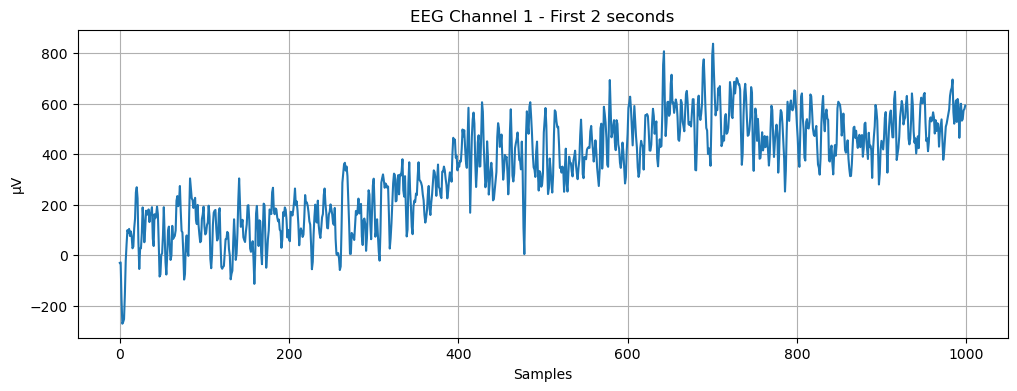

In [13]:
# Settings
fs = 500                   # Sampling rate (Hz)
duration_sec = 2           # Duration to view (seconds)
start_time = 0             # In seconds, adjust as needed
start_sample = start_time * fs
end_sample = start_sample + (duration_sec * fs)

# Slice the data
eeg_segment = eeg_data[start_sample:end_sample, 0]  # Channel 0

# Plot it
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(eeg_segment)
plt.title(f'EEG Channel 1 - First {duration_sec} seconds')
plt.xlabel('Samples')
plt.ylabel('μV')
plt.grid(True)
plt.show()


# Extracting EMG Data


In [12]:
# Access the EMG struct
emg_struct = hs['emg'][0, 0]

# Check what's inside 'sig'
emg_raw = emg_struct['sig']
print("Type of emg_raw:", type(emg_raw))
print("Shape of emg_raw:", emg_raw.shape)

# Unwrap it
if emg_raw.size == 1:
    emg_data = emg_raw.item()
else:
    emg_data = emg_raw
    
# Confirm it worked
print("EMG data shape:", getattr(emg_data, 'shape', 'Not an array'))



Type of emg_raw: <class 'numpy.ndarray'>
Shape of emg_raw: (955969, 5)
EMG data shape: (955969, 5)


# Plotting EMG Channel 0

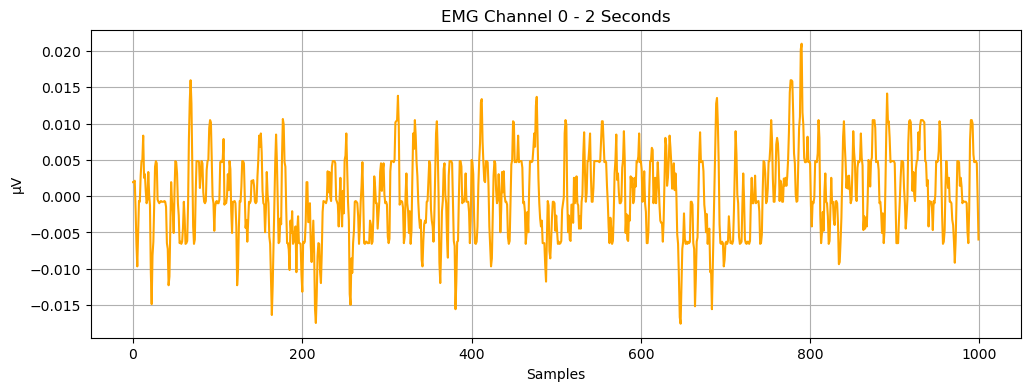

In [ ]:
emg_channel = 0  # or pick another channel
emg_segment = emg_data[start_sample:end_sample, emg_channel]

plt.figure(figsize=(12, 4))
plt.plot(emg_segment, color='orange')
plt.title(f'EMG Channel {emg_channel} - 2 Seconds')
plt.xlabel('Samples')
plt.ylabel('μV')
plt.grid(True)
plt.show()


In [34]:
hs['emg'][0, 0]

hs['emg'][0, 0].dtype.names



('sig', 'names', 'samplingrate')

# Pre-Processing

In [38]:
def bandpass(data, lowcut, highcut, fs, order=4):
    nyq = fs / 2
    b, a = butter(order, [5, 45], btype='band', fs=fs)
    return filtfilt(b, a, data)

# EEG: band-pass (e.g., 5–45 Hz)
eeg_filtered = bandpass(eeg_segment, 5, 45, fs)

# EMG: high-pass + full-wave rectification (EMG is noisy + spiky)
emg_highpassed = bandpass(emg_segment, 20, 250, fs)
emg_rectified = np.abs(emg_highpassed)

# Computing Coherence

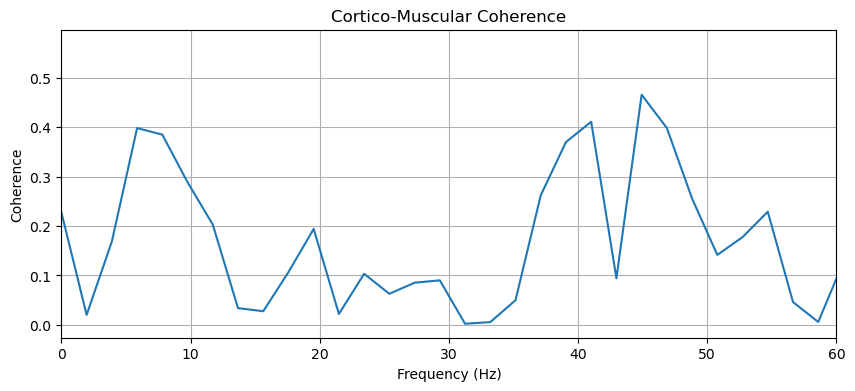

In [39]:
from scipy.signal import coherence
import matplotlib.pyplot as plt

f, Cxy = coherence(eeg_filtered, emg_rectified, fs=fs, nperseg=256)

# Plot it!
plt.figure(figsize=(10, 4))
plt.plot(f, Cxy)
plt.xlim(0, 60)
plt.title("Cortico-Muscular Coherence")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Coherence")
plt.grid(True)
plt.show()